In [ ]:

!pip install -q transformers

# --- Import Libraries ---
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import glob
import time

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

# --- Torchvision Imports ---
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image, to_tensor, resize

# --- Other Imports ---
from sklearn.model_selection import train_test_split
from transformers import SwinModel

# --- Setup Seed for Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Mount Google Drive ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
    print("Google Drive mounted successfully.")
except ImportError:
    DRIVE_MOUNTED = False
    print("Google Drive not detected. Checkpoints will be saved locally to /content/.")

Mounted at /content/drive
Google Drive mounted successfully.


In [ ]:
import os
import zipfile

# Make .kaggle directory
!mkdir -p /root/.kaggle

# --- Upload your kaggle.json file ---

try:
    from google.colab import files
    print("Please upload your kaggle.json file")
    uploaded = files.upload()

    # Move kaggle.json to the correct location
    !mv kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    print("Kaggle API key uploaded.")
except ImportError:
    print("Not in Colab. Please ensure kaggle.json is in /root/.kaggle/")

# Download dataset from Kaggle
!kaggle datasets download -d tanishqgupta3142/dataset1 -p /content

# Extract the ZIP file
zip_path = "/content/dataset1.zip"
extract_path = "/content"
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_path)

print("Extraction complete!")

# Verify content structure
!ls -l /content/Kvasir-SEG/Kvasir-SEG/

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Kaggle API key uploaded.
Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasirseg
License(s): copyright-authors
  0% 0.00/144M [00:00<?, ?B/s]
100% 144M/144M [00:00<00:00, 1.59GB/s]
Extraction complete!
total 4452
-rw-r--r-- 1 root root 4276299 Nov 17 16:59 1911.07069.pdf
drwxr-xr-x 2 root root   65536 Nov 17 16:59 annotated_images
drwxr-xr-x 2 root root   65536 Nov 17 16:59 bbox
drwxr-xr-x 2 root root   65536 Nov 17 16:59 images
drwxr-xr-x 2 root root   65536 Nov 17 16:59 masks


In [ ]:
# --- 1. Core Experiment Parameters ---
TRAINING_SIZE = 25       # Options: 50, 100, 150, 200 (SSL) or 800 (Fully Supervised)
NUM_EPOCHS = 20
START_EPOCH = 0          # Set to > 0 to resume training from 'latest_model.pth'
ITERATIONS_PER_EPOCH = 20 # Number of training batches per epoch (for SSL)
PSEUDO_LABEL_INTERVAL = 5  # Iterations to wait before pseudo-labeling (for SSL)
CONFIDENCE_THRESHOLD = 0.79 # Confidence score to accept a pseudo-label (for SSL)

# --- 2. Paths & Directories ---
BASE_DRIVE_PATH = '/content/drive/MyDrive/capstone-dataset-1/' # Base path in Google Drive
if not DRIVE_MOUNTED:
    BASE_DRIVE_PATH = '/content/capstone-dataset-1/'
    print(f"Warning: Google Drive not mounted. Saving locally to {BASE_DRIVE_PATH}")

# Dynamic run path based on TRAINING_SIZE
RUN_PATH = os.path.join(BASE_DRIVE_PATH, f'{TRAINING_SIZE}/')
PLOT_PATH = os.path.join(RUN_PATH, 'plots/')
LATEST_MODEL_PATH = os.path.join(RUN_PATH, 'latest_model.pth')
BEST_MODEL_PATH = os.path.join(RUN_PATH, 'best_model.pth')

# Create directories
os.makedirs(RUN_PATH, exist_ok=True)
os.makedirs(PLOT_PATH, exist_ok=True)

# Data paths
DATA_ROOT = "/content/CVC-ClinicDB-612"
IMAGE_DIR = os.path.join(DATA_ROOT, "images")
MASK_DIR = os.path.join(DATA_ROOT, "Ground Truth")

# --- 3. Model & Training Hyperparameters ---
IMAGE_SIZE = 224
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"--- Experiment Configuration ---")
print(f"Training Scenario: {'Semi-Supervised' if TRAINING_SIZE < 800 else 'Fully Supervised'}")
print(f"Training Size: {TRAINING_SIZE}")
print(f"Total Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Iterations per Epoch: {ITERATIONS_PER_EPOCH if TRAINING_SIZE < 800 else 'N/A (Full Dataset)'}")
print(f"Device: {DEVICE}")
print(f"Run Path: {RUN_PATH}")
print(f"Plot Path: {PLOT_PATH}")
print(f"---------------------------------")

--- Experiment Configuration ---
Training Scenario: Semi-Supervised
Training Size: 150
Total Epochs: 20
Batch Size: 16
Iterations per Epoch: 20
Device: cuda
Run Path: /content/drive/MyDrive/capstone/150/
Plot Path: /content/drive/MyDrive/capstone/150/plots/
---------------------------------


In [ ]:
# Block 4: Model Architecture (Swin-UNet)

class SwinUNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SwinUNet, self).__init__()
        # Encoder: Pre-trained Swin Transformer
        self.swin = SwinModel.from_pretrained(
            "microsoft/swin-base-patch4-window7-224",
            output_hidden_states=True,
        )

        # Freeze some early layers of the encoder
        for name, param in self.swin.named_parameters():
            if "layers.0" in name or "layers.1" in name or "embed" in name:
                 param.requires_grad = False

        # --- Decoder ---
        # A standard U-Net decoder with skip connections



        self.decoder4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)
        self.conv4 = nn.Sequential(nn.Conv2d(1024, 512, 3, padding=1), nn.ReLU())


        self.decoder3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1), nn.ReLU())


        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU())

        # Final upsampling layers
        self.final_upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True) # Combined upsampling
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )


    def forward(self, x):

        hidden_states = self.swin(x).hidden_states



        # Stage 1: (B, 56*56, 128) -> (B, 128, 56, 56)
        B, L1, C1 = hidden_states[0].shape
        H1 = W1 = int(L1**0.5)
        s1 = hidden_states[0].reshape(B, H1, W1, C1).permute(0, 3, 1, 2)

        # Stage 2: (B, 28*28, 256) -> (B, 256, 28, 28)
        B, L2, C2 = hidden_states[1].shape
        H2 = W2 = int(L2**0.5)
        s2 = hidden_states[1].reshape(B, H2, W2, C2).permute(0, 3, 1, 2)

        # Stage 3: (B, 14*14, 512) -> (B, 512, 14, 14)
        B, L3, C3 = hidden_states[2].shape
        H3 = W3 = int(L3**0.5)
        s3 = hidden_states[2].reshape(B, H3, W3, C3).permute(0, 3, 1, 2)

        # Stage 4: (B, 7*7, 1024) -> (B, 1024, 7, 7)
        B, L4, C4 = hidden_states[3].shape
        H4 = W4 = int(L4**0.5)
        s4 = hidden_states[3].reshape(B, H4, W4, C4).permute(0, 3, 1, 2)

        # --- Decoder Path with Skip Connections ---
        # Upsample d4 to match s3 (7x7 -> 14x14)
        d4 = self.decoder4(s4)
        d4 = torch.cat([d4, s3], dim=1)
        d4 = self.conv4(d4)

        # Upsample d3 to match s2 (14x14 -> 28x28)
        d3 = self.decoder3(d4)
        d3 = torch.cat([d3, s2], dim=1)
        d3 = self.conv3(d3)

        # Upsample d2 to match s1 (28x28 -> 56x56)
        d2 = self.decoder2(d3)
        d2 = torch.cat([d2, s1], dim=1)
        d2 = self.conv2(d2)

        # Final upsampling to 224x224
        out = self.final_upsample(d2)
        out = self.final_conv(out)

        return out

In [ ]:
# Block 5: Loss, Metrics, and Confidence Functions

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (probs_flat * targets_flat).sum()
        dice = (2. * intersection + self.smooth) / (probs_flat.sum() + targets_flat.sum() + self.smooth)
        return 1 - dice

def combined_loss(logits, targets):
    bce = nn.BCEWithLogitsLoss()
    dice = DiceLoss()
    return bce(logits, targets) + dice(logits, targets)

def calculate_metrics(logits, targets, threshold=0.5, epsilon=1e-6):
    """Calculates Intersection over Union (mIoU) and Dice Score."""
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)

    intersection = (preds_flat * targets_flat).sum()

    # Dice Score
    dice_score = (2. * intersection) / (preds_flat.sum() + targets_flat.sum() + epsilon)

    # IoU (Intersection over Union)
    union = preds_flat.sum() + targets_flat.sum() - intersection
    iou_score = (intersection) / (union + epsilon)

    return iou_score.item(), dice_score.item()

def get_confidence_score(probs, pred_mask, epsilon=1e-6):
    confidence = (probs * pred_mask).sum() / (pred_mask.sum() + epsilon)
    return confidence.item()

In [ ]:
# Block 6: Custom Dataset Class

from PIL import Image

class PolypDataset(Dataset):
    def __init__(self, image_filenames, image_dir, mask_dir, transform=None, pseudo_masks=None):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.pseudo_masks = pseudo_masks if pseudo_masks is not None else {}


        self.image_transform = T.Compose([
            T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = T.Compose([
            T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = Image.open(img_path).convert("RGB")

        if filename in self.pseudo_masks:

            mask_np = self.pseudo_masks[filename]

            mask = Image.fromarray((mask_np * 255).astype(np.uint8))
        else:

            mask_path = os.path.join(self.mask_dir, filename)
            mask = Image.open(mask_path).convert("L")



        image = self.image_transform(image)
        mask = self.mask_transform(mask)


        mask = (mask > 0.5).float()

        return image, mask, filename

In [ ]:
# Block 7: Data Loading & Splitting

all_filenames = sorted(os.listdir(IMAGE_DIR))


train_pool_files, val_pool_files = train_test_split(
    all_filenames,
    test_size=0.2,
    random_state=SEED
)

print(f"Total Images: {len(all_filenames)}")
print(f"Main Training Pool (80%): {len(train_pool_files)} images")
print(f"Fixed Validation Pool (20%): {len(val_pool_files)} images")


# --- Define Datasets & DataLoaders ---

val_dataset = PolypDataset(
    image_filenames=val_pool_files,
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

pseudo_masks = {}
labeled_pool_sizes = []

if TRAINING_SIZE == 800:
    print(f"Running Scenario B: Fully Supervised with {TRAINING_SIZE} images.")
    labeled_pool_files = train_pool_files
    unlabeled_pool_files = []

    train_dataset = PolypDataset(
        image_filenames=labeled_pool_files,
        image_dir=IMAGE_DIR,
        mask_dir=MASK_DIR
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

else:

    print(f"Running Scenario A: Semi-Supervised with {TRAINING_SIZE} initial labels.")

    labeled_pool_files = train_pool_files[:TRAINING_SIZE]
    unlabeled_pool_files = train_pool_files[TRAINING_SIZE:]


    train_loader = None

    print(f"Initial Labeled Pool: {len(labeled_pool_files)} images")
    print(f"Initial Unlabeled Pool: {len(unlabeled_pool_files)} images")

Total Images: 1000
Main Training Pool (80%): 800 images
Fixed Validation Pool (20%): 200 images
Running Scenario A: Semi-Supervised with 150 initial labels.
Initial Labeled Pool: 150 images
Initial Unlabeled Pool: 650 images


In [ ]:
# Block 8: Visualization Utilities (Requirement 4)

def save_loss_metric_plots(train_losses, val_losses, train_metrics, val_metrics, current_epoch, save_path):
    """Saves plots for loss and metrics vs. epoch."""
    epochs = range(1, current_epoch + 1)

    # --- Loss Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.title(f'Training vs. Validation Loss (Epoch {current_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_path, f'loss_curve_epoch_{current_epoch}.png'))
    plt.close()

    # --- Metric (mIoU) Plot ---
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_metrics, 'b-o', label='Training mIoU')
    plt.plot(epochs, val_metrics, 'r-o', label='Validation mIoU')
    plt.title(f'Training vs. Validation mIoU (Epoch {current_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_path, f'miou_curve_epoch_{current_epoch}.png'))
    plt.close()

def save_data_growth_plot(pool_sizes, current_epoch, save_path):
    """Saves a bar chart of the labeled pool size growth."""
    if not pool_sizes:
        return

    epochs = range(1, current_epoch + 1)
    plt.figure(figsize=(10, 5))
    plt.bar(epochs, pool_sizes, color='green')
    plt.title(f'Labeled Pool Size Growth (Epoch {current_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Number of Labeled Samples')
    plt.xticks(epochs)
    plt.grid(axis='y', linestyle='--')
    plt.savefig(os.path.join(save_path, f'data_growth_epoch_{current_epoch}.png'))
    plt.close()

def save_new_labels_plot(new_labels, current_epoch, save_path):
    """Saves a bar chart of the new pseudo-labels added per epoch."""
    if not new_labels:
        return

    epochs = range(1, current_epoch + 1)
    plt.figure(figsize=(10, 5))
    plt.bar(epochs, new_labels, color='dodgerblue')
    plt.title(f'New Pseudo-Labels Added Per Epoch (Epoch {current_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Number of New Samples Added')
    plt.xticks(epochs)
    plt.grid(axis='y', linestyle='--')
    plt.savefig(os.path.join(save_path, f'new_labels_per_epoch_{current_epoch}.png'))
    plt.close()

def save_sample_predictions(model, loader, device, epoch, save_path, num_samples=3, save_to_disk=True, display_to_notebook=False):
    """Saves and/or displays 3-panel sample predictions (Image, Ground Truth, Prediction)."""
    model.eval()

    images, masks, _ = next(iter(loader)) # Get one batch
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

    # Move to CPU for plotting
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    # De-normalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(min(num_samples, len(images))):
        img = (images[i] * std) + mean # De-normalize
        img = to_pil_image(img)

        # Squeeze the channel dimension (1, H, W) -> (H, W) for masks
        gt_mask = to_pil_image(masks[i].squeeze(0))
        pred_mask = to_pil_image(preds[i].squeeze(0))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        ax1.imshow(img)
        ax1.set_title("Original Image")
        ax1.axis('off')

        ax2.imshow(gt_mask, cmap='gray')
        ax2.set_title("Ground Truth Mask")
        ax2.axis('off')

        ax3.imshow(pred_mask, cmap='gray')
        ax3.set_title("Predicted Mask")
        ax3.axis('off')

        plt.suptitle(f'Epoch {epoch} - Sample {i+1}')
        plt.tight_layout()

        if save_to_disk:
            plt.savefig(os.path.join(save_path, f'epoch_{epoch}_val_sample_{i+1}.png'))

        if display_to_notebook:
            plt.show()

        plt.close(fig) # Close the figure to free up memory

    model.train()

In [ ]:
# Block 9: Model, Optimizer, & Checkpoint Loading

model = SwinUNet(num_classes=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = combined_loss

train_losses = []
val_losses = []
train_mious = []
val_mious = []
labeled_pool_sizes = []
new_labels_per_epoch = []
best_iou = 0.0


if START_EPOCH > 0:
    if os.path.exists(LATEST_MODEL_PATH):
        print(f"Loading checkpoint from: {LATEST_MODEL_PATH}")


        try:
            checkpoint = torch.load(LATEST_MODEL_PATH, weights_only=False)
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Trying to load with map_location='cpu'...")

            checkpoint = torch.load(LATEST_MODEL_PATH, weights_only=False, map_location=torch.device('cpu'))


        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Load history to resume plotting
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        train_mious = checkpoint.get('train_mious', [])
        val_mious = checkpoint.get('val_mious', [])
        labeled_pool_sizes = checkpoint.get('labeled_pool_sizes', [])
        new_labels_per_epoch = checkpoint.get('new_labels_per_epoch', [])

        best_iou = checkpoint.get('best_iou', 0.0)

        if checkpoint['epoch'] != (START_EPOCH - 1):
            print(f"Warning: Checkpoint epoch ({checkpoint['epoch']}) does not match START_EPOCH-1 ({START_EPOCH-1}).")
            print(f"Starting from checkpoint epoch {checkpoint['epoch'] + 1} instead.")
            START_EPOCH = checkpoint['epoch'] + 1

        print(f"Resuming training from Epoch {START_EPOCH}")
    else:
        print(f"Warning: START_EPOCH > 0 but no checkpoint found at {LATEST_MODEL_PATH}. Starting from scratch.")
        START_EPOCH = 0
else:
    print("Starting training from scratch (Epoch 0).")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Starting training from scratch (Epoch 0).


In [ ]:
# Block 10: Main Training & Validation Loop (Corrected)

print("--- Starting Training ---")
start_time = time.time()


for epoch in range(START_EPOCH, NUM_EPOCHS):
    print(f"\n{'='*30}")
    print(f" EPOCH {epoch + 1} / {NUM_EPOCHS}")
    print(f"{'='*30}")

    model.train()
    epoch_train_losses = []
    epoch_train_mious = []


    if TRAINING_SIZE == 800:
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
        for images, masks, _ in pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            # Standard training step
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            # Calculate metrics
            miou, dice = calculate_metrics(logits.detach(), masks)
            epoch_train_losses.append(loss.item())
            epoch_train_mious.append(miou)

            pbar.set_postfix(loss=f"{loss.item():.4f}", mIoU=f"{miou:.4f}")

    else:

        print("Resetting pools for new epoch...")

        current_epoch_labeled_files = list(labeled_pool_files)
        current_epoch_unlabeled_files = list(unlabeled_pool_files)
        pseudo_masks_for_this_epoch = {}

        print(f"Starting Epoch with Labeled: {len(current_epoch_labeled_files)}, Unlabeled: {len(current_epoch_unlabeled_files)}")


        current_train_dataset = PolypDataset(
            image_filenames=current_epoch_labeled_files,
            image_dir=IMAGE_DIR,
            mask_dir=MASK_DIR,
            pseudo_masks=pseudo_masks_for_this_epoch
        )
        current_train_loader = DataLoader(
            current_train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2,
            drop_last=True
        )

        pbar = tqdm(range(ITERATIONS_PER_EPOCH), desc=f"Epoch {epoch+1} Iterations")
        train_iter = iter(current_train_loader)

        newly_labeled_data_for_epoch = {}
        to_remove_indices_for_epoch = set()


        for i in pbar:
            try:
                images, masks, _ = next(train_iter)
            except StopIteration:
                train_iter = iter(current_train_loader)
                images, masks, _ = next(train_iter)

            images, masks = images.to(DEVICE), masks.to(DEVICE)


            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            miou, dice = calculate_metrics(logits.detach(), masks)
            epoch_train_losses.append(loss.item())
            epoch_train_mious.append(miou)
            pbar.set_postfix(loss=f"{loss.item():.4f}", mIoU=f"{miou:.4f}")


            indices_to_check = [idx for idx in range(len(current_epoch_unlabeled_files)) if idx not in to_remove_indices_for_epoch]

            if i > 0 and i % PSEUDO_LABEL_INTERVAL == 0 and len(indices_to_check) > 0:
                model.eval()
                temp_new_labels = {}
                temp_to_remove = []

                for idx in tqdm(indices_to_check, desc="Pseudo-Labeling", leave=False):
                    filename = current_epoch_unlabeled_files[idx]

                    img_path = os.path.join(IMAGE_DIR, filename)
                    image = Image.open(img_path).convert("RGB")
                    image_tensor = val_dataset.image_transform(image)

                    with torch.no_grad():
                        logits_pl = model(image_tensor.unsqueeze(0).to(DEVICE))

                    probs_pl = torch.sigmoid(logits_pl.squeeze(0))
                    pred_mask_pl = (probs_pl > 0.5).float()
                    confidence = get_confidence_score(probs_pl, pred_mask_pl)

                    if confidence >= CONFIDENCE_THRESHOLD:
                        pseudo_mask_np = pred_mask_pl.cpu().numpy().squeeze()
                        temp_new_labels[filename] = pseudo_mask_np
                        temp_to_remove.append(idx)

                model.train()
                newly_labeled_data_for_epoch.update(temp_new_labels)
                to_remove_indices_for_epoch.update(temp_to_remove)
                pbar.set_description(f"Epoch {epoch+1} Iterations (Added {len(temp_new_labels)} new labels)")


            if len(current_epoch_unlabeled_files) == len(to_remove_indices_for_epoch):
                print("Unlabeled pool is empty. Finishing epoch early.")
                break


        num_new_labels_this_epoch = len(newly_labeled_data_for_epoch)

        if newly_labeled_data_for_epoch:

            pseudo_masks_for_this_epoch.update(newly_labeled_data_for_epoch)
            new_filenames = list(newly_labeled_data_for_epoch.keys())
            current_epoch_labeled_files.extend(new_filenames)
            current_epoch_unlabeled_files = [f for f in current_epoch_unlabeled_files if f not in new_filenames]


            current_train_dataset = PolypDataset(
                image_filenames=current_epoch_labeled_files,
                image_dir=IMAGE_DIR,
                mask_dir=MASK_DIR,
                pseudo_masks=pseudo_masks_for_this_epoch
            )
            current_train_loader = DataLoader(
                current_train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=2,
                drop_last=True
            )
            train_iter = iter(current_train_loader)

        print(f"End of Epoch. Final Labeled Pool: {len(current_epoch_labeled_files)}, Final Unlabeled Pool: {len(current_epoch_unlabeled_files)}")

        # Log metrics for plotting
        labeled_pool_sizes.append(len(current_epoch_labeled_files))
        new_labels_per_epoch.append(num_new_labels_this_epoch)


    model.eval()
    epoch_val_losses = []
    epoch_val_mious = []

    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")
        for val_images, val_masks, _ in pbar_val:
            val_images, val_masks = val_images.to(DEVICE), val_masks.to(DEVICE)
            val_logits = model(val_images)
            val_loss = criterion(val_logits, val_masks)
            val_miou, val_dice = calculate_metrics(val_logits, val_masks)
            epoch_val_losses.append(val_loss.item())
            epoch_val_mious.append(val_miou)
            pbar_val.set_postfix(val_loss=f"{val_loss.item():.4f}", val_mIoU=f"{val_miou:.4f}")


    avg_train_loss = np.mean(epoch_train_losses)
    avg_val_loss = np.mean(epoch_val_losses)
    avg_train_miou = np.mean(epoch_train_mious)
    avg_val_miou = np.mean(epoch_val_mious)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mious.append(avg_train_miou)
    val_mious.append(avg_val_miou)

    if TRAINING_SIZE == 800:
        labeled_pool_sizes.append(TRAINING_SIZE)
        new_labels_per_epoch.append(0)

    print(f"\n--- Epoch {epoch+1} Summary ---")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Train mIoU: {avg_train_miou:.4f} | Val mIoU: {avg_val_miou:.4f}")


    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_iou': best_iou,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_mious': train_mious,
        'val_mious': val_mious,
        'labeled_pool_sizes': labeled_pool_sizes,
        'new_labels_per_epoch': new_labels_per_epoch,

    }


    torch.save(checkpoint_data, LATEST_MODEL_PATH)
    print(f"Saved latest model checkpoint to {LATEST_MODEL_PATH}")


    if avg_val_miou > best_iou:
        print(f"New best model found! mIoU improved from {best_iou:.4f} to {avg_val_miou:.4f}")
        best_iou = avg_val_miou
        checkpoint_data['best_iou'] = best_iou
        torch.save(checkpoint_data, BEST_MODEL_PATH)
        print(f"Saved new best model to {BEST_MODEL_PATH}")



    try:

        save_loss_metric_plots(train_losses, val_losses, train_mious, val_mious, epoch + 1, PLOT_PATH)


        save_data_growth_plot(labeled_pool_sizes, epoch + 1, PLOT_PATH)


        save_new_labels_plot(new_labels_per_epoch, epoch + 1, PLOT_PATH)


        save_sample_predictions(model, val_loader, DEVICE, epoch + 1, PLOT_PATH, num_samples=3, save_to_disk=True, display_to_notebook=True)

        print(f"Saved plots to {PLOT_PATH}")

    except Exception as e:
        print(f"An error occurred during visualization: {e}")


end_time = time.time()
print(f"\n{'='*30}")
print(f"--- Training Complete ---")
print(f"Total time: {(end_time - start_time) / 60:.2f} minutes")
print(f"Best Validation mIoU: {best_iou:.4f}")
print(f"Checkpoints and plots saved to: {RUN_PATH}")
print(f"{'='*30}")

Loading best model for final visualization...
Loading best model from /content/drive/MyDrive/capstone/150/best_model.pth...
Successfully loaded best model.
Best Model Validation mIoU: 0.7776 (from Epoch 20)

Displaying 5 sample predictions from the best model:


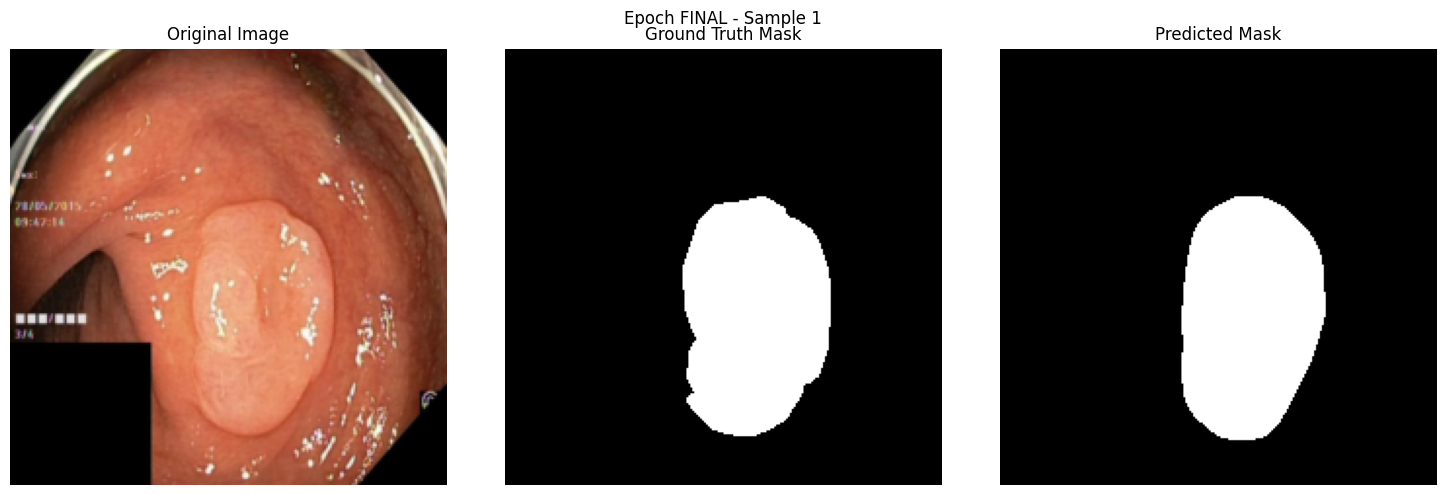

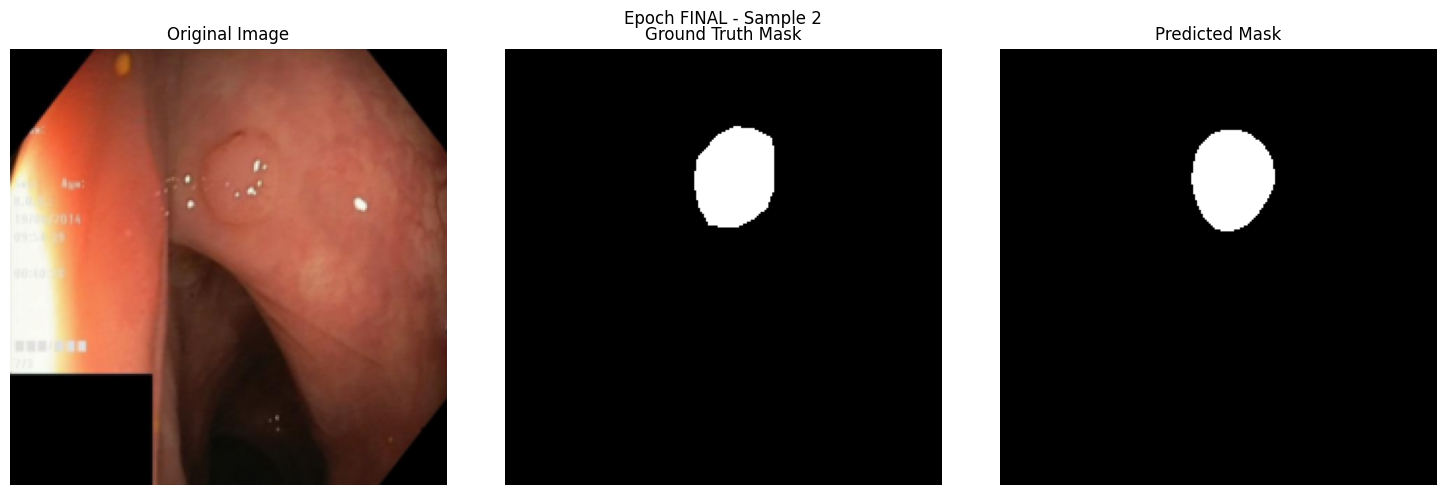

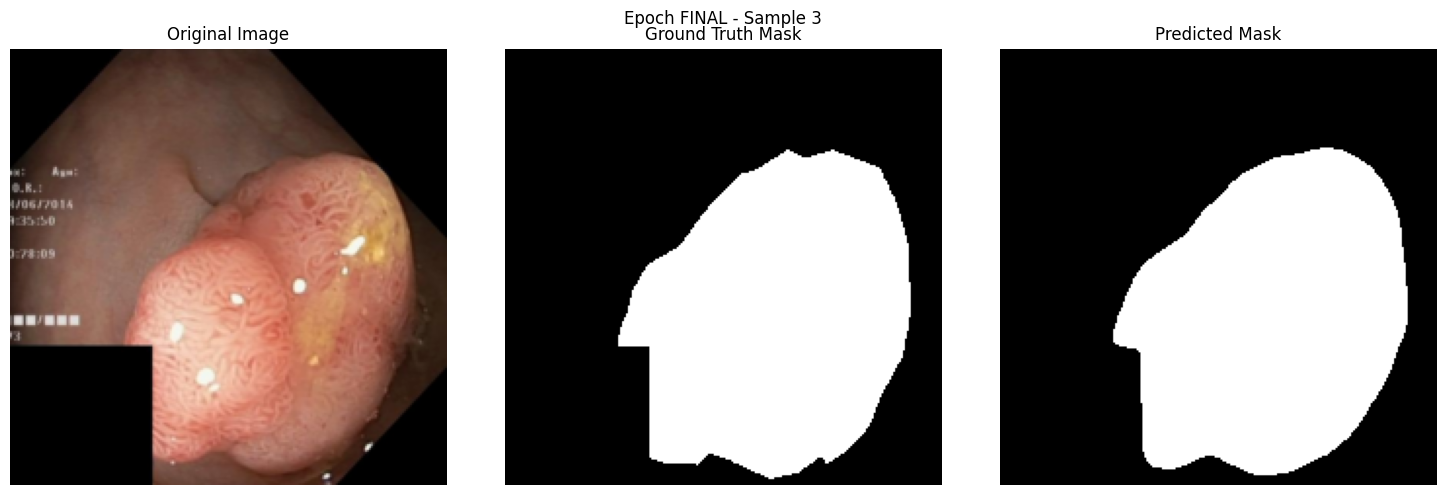

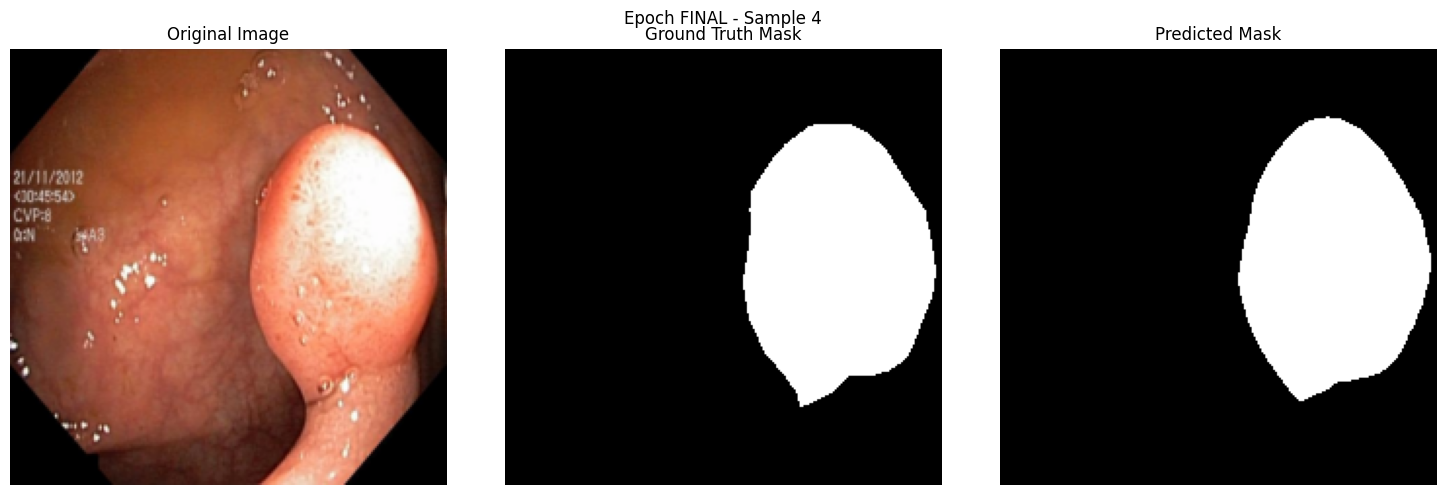

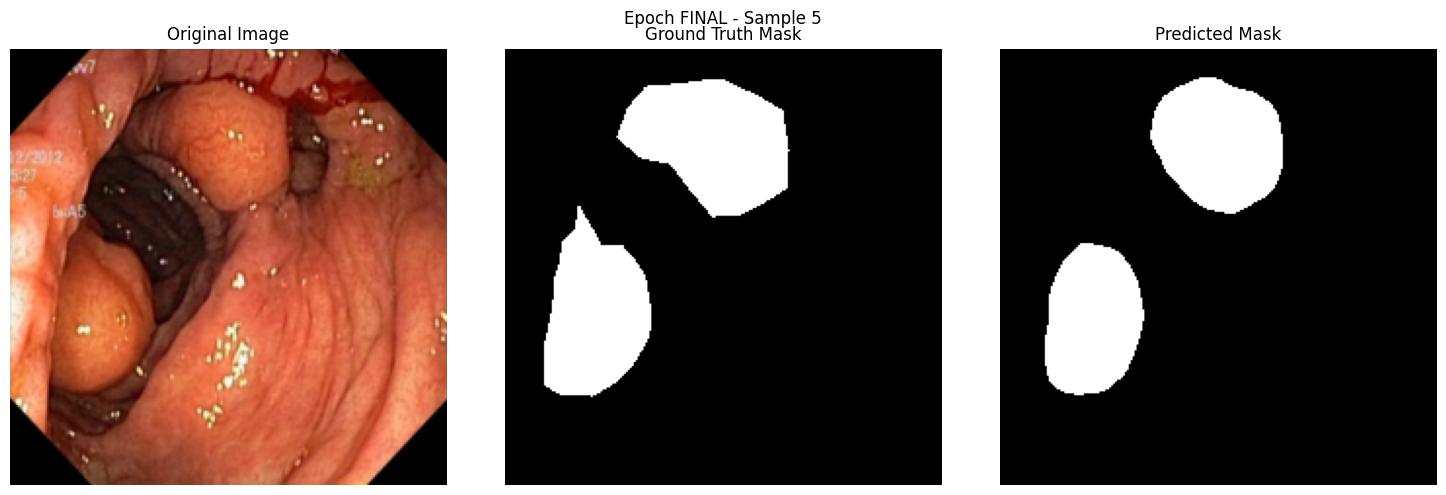

In [ ]:


print("Loading best model for final visualization...")

# Initialize a new model instance
final_model = SwinUNet(num_classes=1).to(DEVICE)

try:

    print(f"Loading best model from {BEST_MODEL_PATH}...")
    try:
        checkpoint = torch.load(BEST_MODEL_PATH, weights_only=False)
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Trying to load with map_location='cpu'...")
        checkpoint = torch.load(BEST_MODEL_PATH, weights_only=False, map_location=torch.device('cpu'))

    final_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Successfully loaded best model.")
    print(f"Best Model Validation mIoU: {checkpoint['best_iou']:.4f} (from Epoch {checkpoint['epoch']+1})")


    print("\nDisplaying 5 sample predictions from the best model:")
    save_sample_predictions(
        final_model,
        val_loader,
        DEVICE,
        epoch="FINAL",
        save_path=PLOT_PATH,
        num_samples=5,
        save_to_disk=False,
        display_to_notebook=True
    )

except FileNotFoundError:
    print(f"Error: 'best_model.pth' not found at {BEST_MODEL_PATH}. Was training completed?")
except Exception as e:
    print(f"An error occurred: {e}")

--- Displaying all 140 saved images from /content/drive/MyDrive/capstone/150/plots/ ---


## Final Loss & Metric Plots

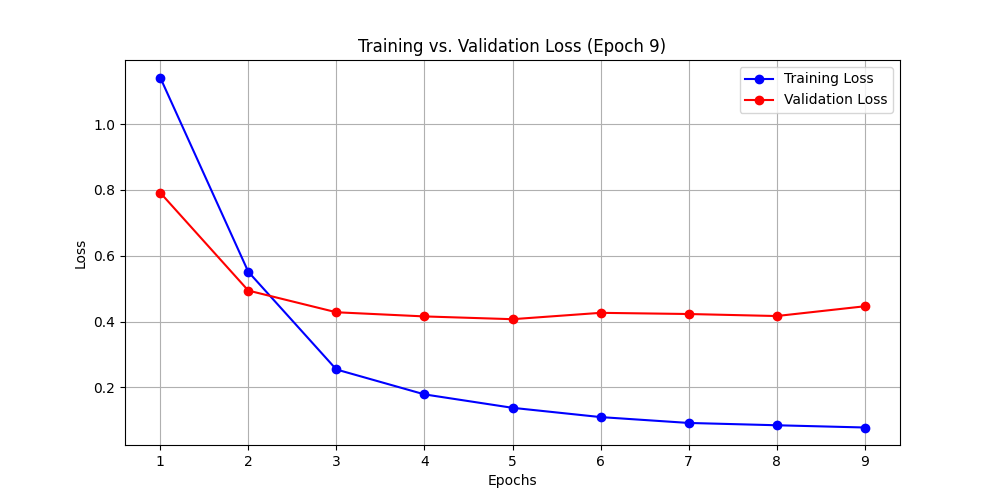

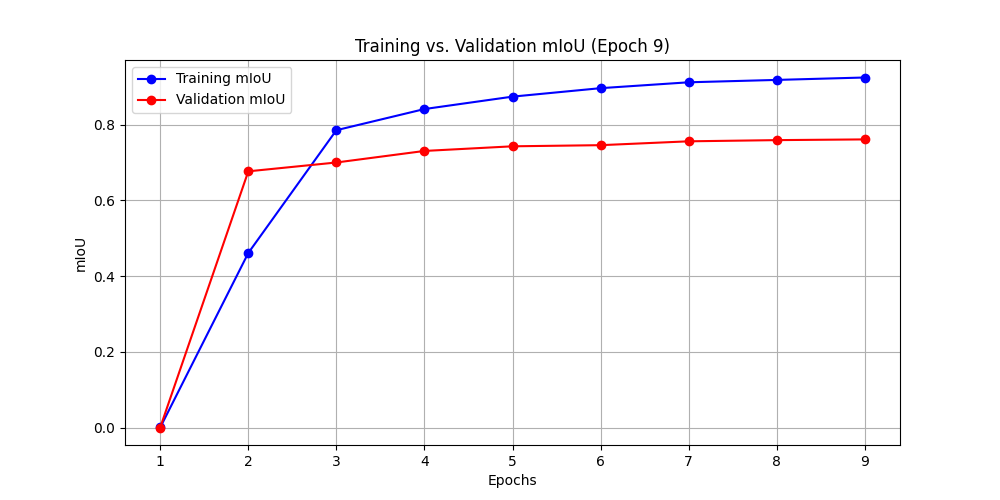

## Final SSL Plots

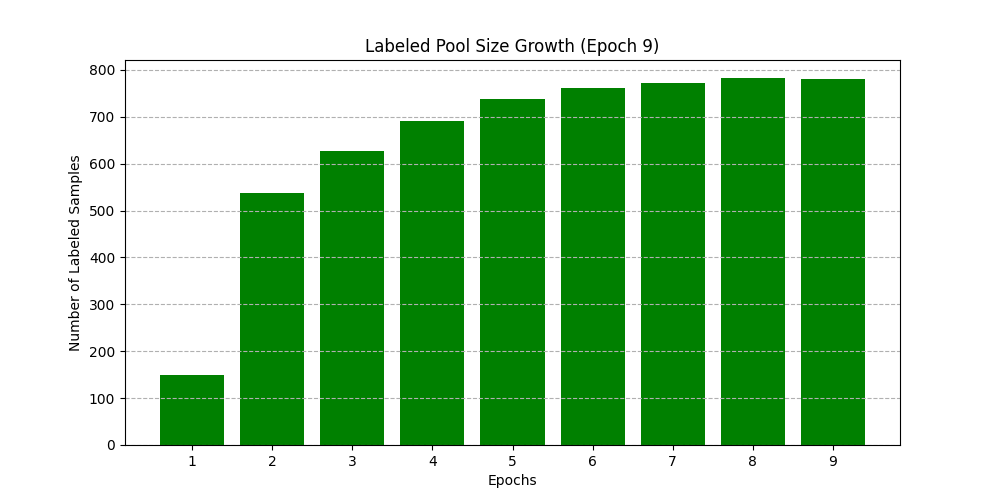

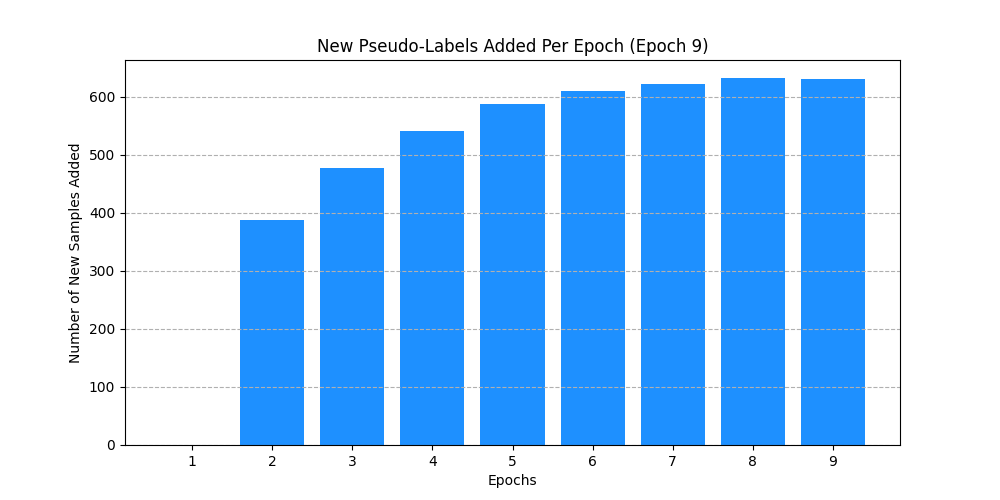

## Sample Predictions (from last epoch)

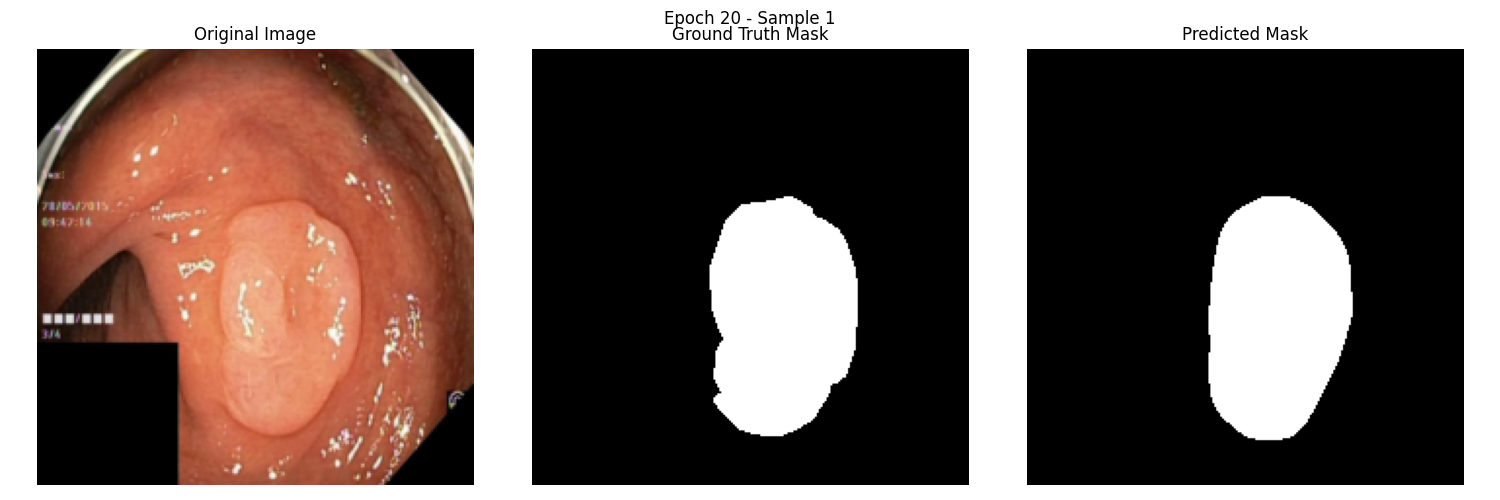

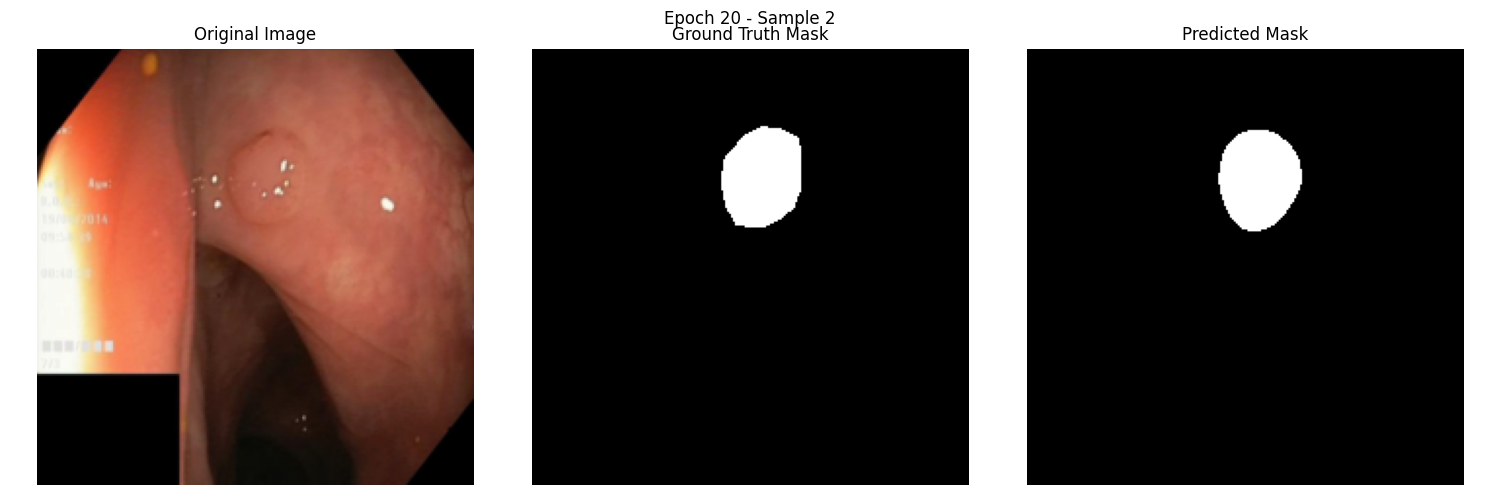

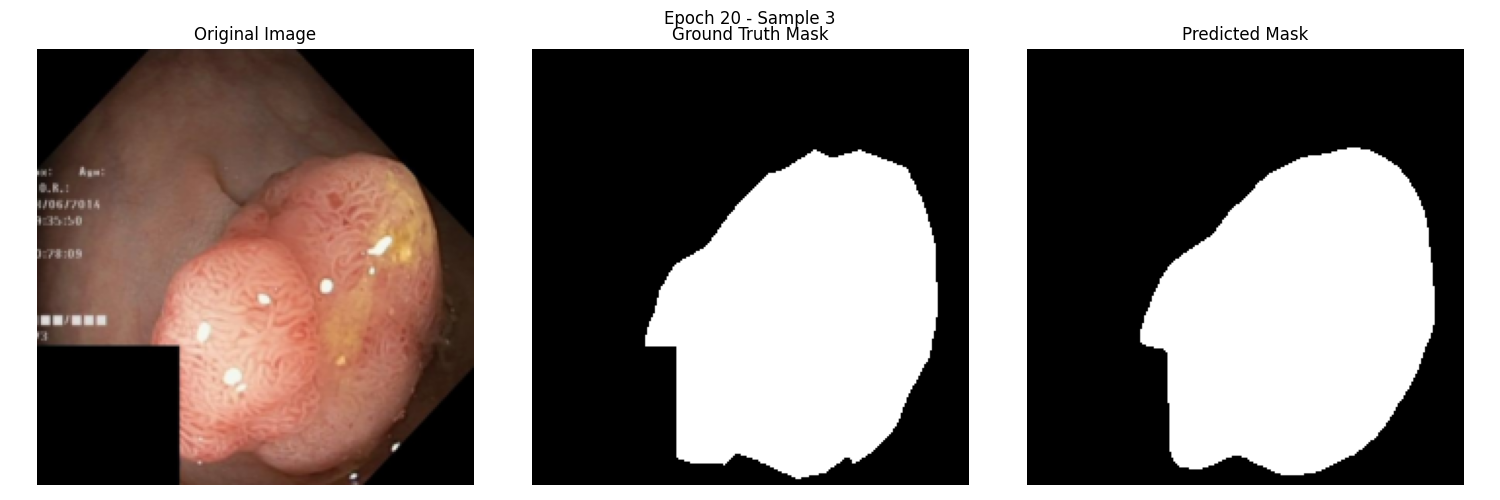

In [ ]:
# Block 12: Load and Display All Saved Graphs

import glob
from IPython.display import Image, display, Markdown

# Find all plot PNG files, sorted
plot_files = sorted(glob.glob(os.path.join(PLOT_PATH, '*.png')))

if not plot_files:
    print(f"No plots found in {PLOT_PATH}. Did training run and save plots?")
else:
    print(f"--- Displaying all {len(plot_files)} saved images from {PLOT_PATH} ---")



    loss_plots = sorted([f for f in plot_files if 'loss_curve' in f], reverse=True)
    miou_plots = sorted([f for f in plot_files if 'miou_curve' in f], reverse=True)
    growth_plots = sorted([f for f in plot_files if 'data_growth' in f], reverse=True)
    new_labels_plots = sorted([f for f in plot_files if 'new_labels' in f], reverse=True)
    samples = sorted([f for f in plot_files if 'val_sample' in f]) # Show samples normally


    display(Markdown("## Final Loss & Metric Plots"))
    if loss_plots:
        display(Image(filename=loss_plots[0], width=600))
    if miou_plots:
        display(Image(filename=miou_plots[0], width=600))

    display(Markdown("## Final SSL Plots"))
    if growth_plots:
        display(Image(filename=growth_plots[0], width=600))
    if new_labels_plots:
        display(Image(filename=new_labels_plots[0], width=600))

    #
    display(Markdown("## Sample Predictions (from last epoch)"))
    last_epoch_samples = [f for f in samples if f"epoch_{NUM_EPOCHS}" in f]
    if not last_epoch_samples:
        last_epoch_samples = samples[-3:] # Fallback to just last 3

    for f in last_epoch_samples:
        display(Image(filename=f, width=600))

In [ ]:
pip install pillow

In [ ]:
!pip install Image


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 61.1 MB/s eta 0:00:00
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=dd7472667c418180b780e7778e7256df0e446b7318332a2aee2b66cc775f3a54
  Stored in directory: /root/.cache/pip/wheels/58/30/d8/3212cd83eeeeee0a1f0c7b9b7bd0674a2b9f09342870473a2a
Successfully built Image


In [ ]:


print("\n--- Loading best model for final evaluation ---")
try:
    # Load the best model checkpoint
    try:
        checkpoint = torch.load(BEST_MODEL_PATH, weights_only=False, map_location=DEVICE)
    except TypeError:
        print("weights_only=False failed, trying without...")
        checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)

    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded from {BEST_MODEL_PATH} (Epoch {checkpoint['epoch']+1}, mIoU: {checkpoint['best_iou']:.4f})")


    model.eval()
    final_val_losses = []
    final_val_mious = []
    final_val_dices = []

    with torch.no_grad():
        pbar_final_val = tqdm(val_loader, desc="Final Validation")
        for val_images, val_masks, _ in pbar_final_val:
            val_images, val_masks = val_images.to(DEVICE), val_masks.to(DEVICE)
            val_logits = model(val_images)

            val_loss = criterion(val_logits, val_masks)
            val_miou, val_dice = calculate_metrics(val_logits, val_masks)

            final_val_losses.append(val_loss.item())
            final_val_mious.append(val_miou)
            final_val_dices.append(val_dice)

            pbar_final_val.set_postfix(
                val_loss=f"{val_loss.item():.4f}",
                val_mIoU=f"{val_miou:.4f}",
                val_Dice=f"{val_dice:.4f}"
            )

    avg_final_val_loss = np.mean(final_val_losses)
    avg_final_val_miou = np.mean(final_val_mious)
    avg_final_val_dice = np.mean(final_val_dices)

    print(f"\n--- Final Evaluation (Best Model) ---")
    print(f"Val Loss: {avg_final_val_loss:.4f}")
    print(f"Val mIoU: {avg_final_val_miou:.4f}")
    print(f"Val Dice: {avg_final_val_dice:.4f}")

    # Save final sample predictions
    print("Saving final sample predictions from best model...")
    save_sample_predictions(
        model,
        val_loader,
        DEVICE,
        epoch="best",
        save_path=PLOT_PATH,
        num_samples=5,
        save_to_disk=True,
        display_to_notebook=False
    )


    print("NOTE: Google Drive upload skipped (not supported on Kaggle).")
    print(f"Find your plots in folder: {PLOT_PATH}")

except FileNotFoundError:
    print(f"Error: 'best_model.pth' not found at {BEST_MODEL_PATH}. Was training completed?")
except Exception as e:
    print(f"An error occurred: {e}")


--- Loading best model for final evaluation ---
Best model loaded from /content/drive/MyDrive/capstone/150/best_model.pth (Epoch 20, mIoU: 0.7776)


Final Validation:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
TRAINING_SIZES_TO_COMPARE = [25, 50, 75, 100]
print(f"Training sizes to compare: {TRAINING_SIZES_TO_COMPARE}")

Training sizes to compare: [50, 100, 150, 200, 800]


Saved performance comparison plot to /content/drive/MyDrive/capstone/150/plots/performance_comparison_bar_chart_with_labels.png


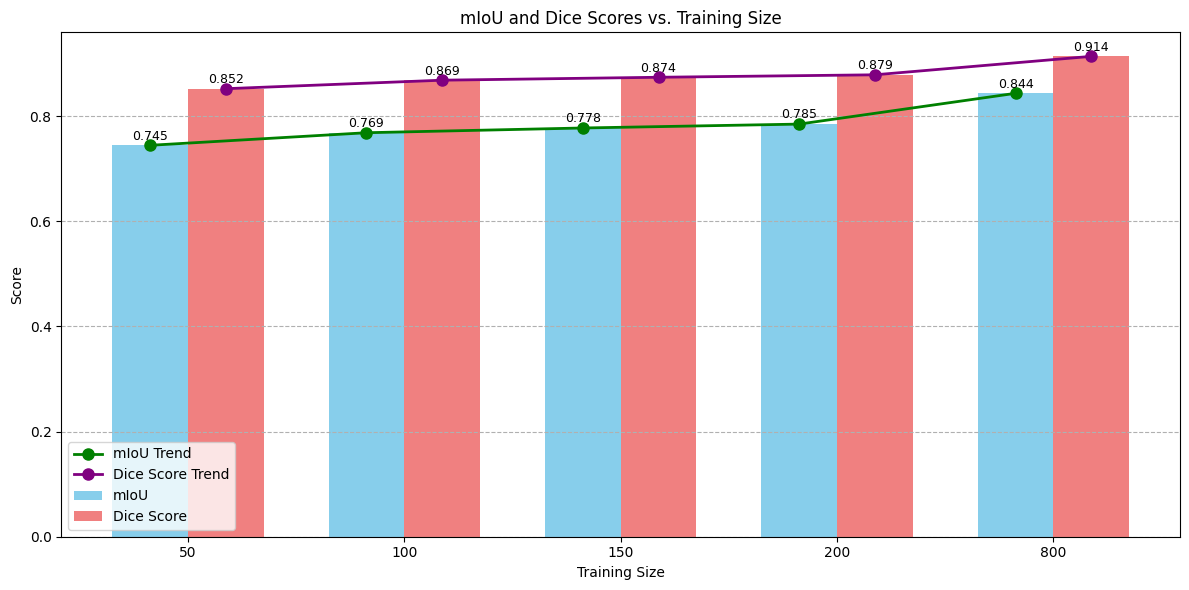

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


os.makedirs(PLOT_PATH, exist_ok=True)


mious_for_plot = [float(x) for x in avg_miou_per_training_size]
dices_for_plot = [float(x) for x in avg_dice_per_training_size]


bar_width = 0.35


ind = np.arange(len(TRAINING_SIZES_TO_COMPARE))

plt.figure(figsize=(12, 6))


plt.bar(ind - bar_width/2, mious_for_plot, bar_width, label='mIoU', color='skyblue')


plt.bar(ind + bar_width/2, dices_for_plot, bar_width, label='Dice Score', color='lightcoral')


plt.plot(ind - bar_width/2, mious_for_plot, color='green', marker='o', linestyle='-', linewidth=2, label='mIoU Trend', markersize=8)

plt.plot(ind + bar_width/2, dices_for_plot, color='purple', marker='o', linestyle='-', linewidth=2, label='Dice Score Trend', markersize=8)


for i, val in enumerate(mious_for_plot):
    plt.text(ind[i] - bar_width/2, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=9)


for i, val in enumerate(dices_for_plot):
    plt.text(ind[i] + bar_width/2, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=9)


plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('mIoU and Dice Scores vs. Training Size')
plt.xticks(ind, TRAINING_SIZES_TO_COMPARE)
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()


plot_filename = os.path.join(PLOT_PATH, 'performance_comparison_bar_chart_with_labels.png')
plt.savefig(plot_filename)
print(f"Saved performance comparison plot to {plot_filename}")


plt.show()

In [ ]:
!pip install torchinfo
import torchinfo

model_for_summary = SwinUNet(num_classes=1).to(DEVICE)


input_size = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)

print("--- Model Architecture Summary ---")

torchinfo.summary(model_for_summary, input_size=input_size)

--- Model Architecture Summary ---


Layer (type:depth-idx)                                            Output Shape              Param #
SwinUNet                                                          [16, 1, 224, 224]         --
├─SwinModel: 1-1                                                  [16, 128, 56, 56]         --
│    └─SwinEmbeddings: 2-1                                        [16, 3136, 128]           --
│    │    └─SwinPatchEmbeddings: 3-1                              [16, 3136, 128]           (6,272)
│    │    └─LayerNorm: 3-2                                        [16, 3136, 128]           (256)
│    │    └─Dropout: 3-3                                          [16, 3136, 128]           --
│    └─SwinEncoder: 2-2                                           [16, 128, 56, 56]         --
│    │    └─ModuleList: 3-4                                       --                        86,734,648
│    └─LayerNorm: 2-3                                             [16, 49, 1024]            2,048
│    └─AdaptiveAvgPool1d: 